# Importing The Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, img_as_float
from skimage.util import random_noise
import cv2
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
np.random.seed(42)
torch.manual_seed(42)

# Loading + Preprocessing The Image

(-0.5, 511.5, 511.5, -0.5)

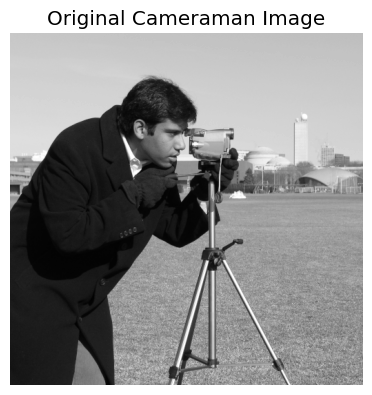

In [4]:
image = data.camera()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Cameraman Image')
plt.axis('off')

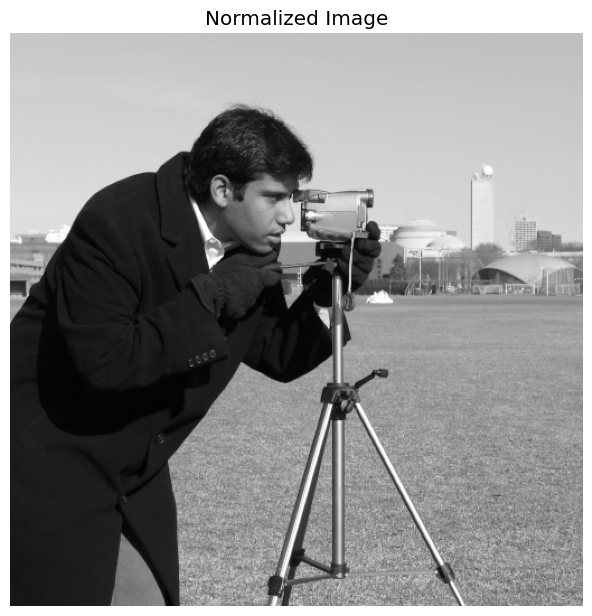

In [5]:
image_float = img_as_float(image)

plt.subplot(1, 2, 2)
plt.imshow(image_float, cmap='gray')
plt.title('Normalized Image')
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
height, width = image_float.shape
print(f"Image dimensions: {height} x {width}")
print(f"Min and max values: {image_float.min():.4f}, {image_float.max():.4f}")

Image dimensions: 512 x 512
Min and max values: 0.0000, 1.0000


# Adding Noise to Image

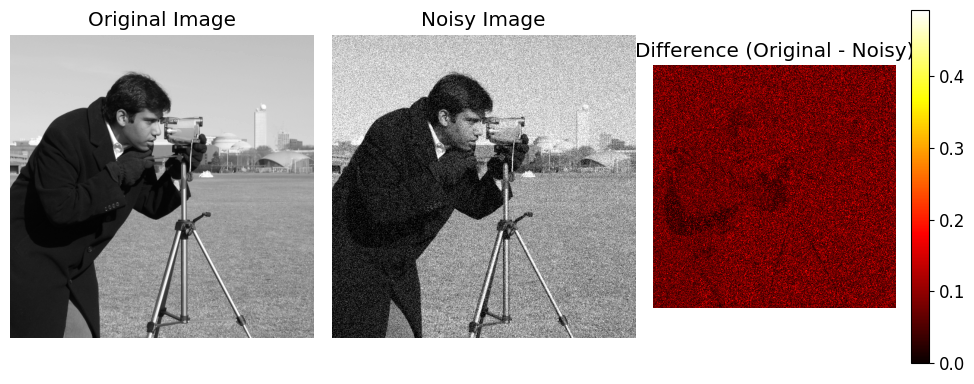

In [7]:
noisy_image = random_noise(image_float, mode='gaussian', var=0.01, seed=42)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_float, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(image_float - noisy_image), cmap='hot')
plt.title('Difference (Original - Noisy)')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()

In [8]:
X = image_float 
X_noisy = noisy_image  
noise_error = np.linalg.norm(X - X_noisy, 'fro')
print(f"Frobenius norm error of noisy image: {noise_error:.4f}")

Frobenius norm error of noisy image: 48.7774


# Reconstruction with SVD

In [9]:
U, S, Vt = np.linalg.svd(X_noisy, full_matrices=False)

full_rank = len(S)
print(f"Full rank of image: {full_rank}")

Full rank of image: 512


In [10]:
errors_svd = []
reconstructed_images_svd = []

max_r_for_plot = min(100, full_rank)
ranks = list(range(1, max_r_for_plot + 1))

for r in ranks:
    X_reconstructed = U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :]
    reconstructed_images_svd.append(X_reconstructed)
    
    error = np.linalg.norm(X - X_reconstructed, 'fro')
    errors_svd.append(error)

errors_svd = np.array(errors_svd)

diff_errors = np.diff(errors_svd)
diff2_errors = np.diff(diff_errors)

threshold = 0.01 * np.max(np.abs(diff2_errors))
inflection_points = np.where(np.abs(diff2_errors) < threshold)[0]

if len(inflection_points) > 0:
    r_opt_svd = inflection_points[0] + 2  
else:
    error_reduction = errors_svd[0] - errors_svd
    target_reduction = 0.95 * error_reduction[-1]  
    r_opt_svd = np.argmax(error_reduction >= target_reduction) + 1

print(f"Optimal rank for SVD (r*_SVD): {r_opt_svd}")

Optimal rank for SVD (r*_SVD): 8


# Reconstruction with PCA

In [11]:
pca_img = PCA()
pca_img.fit(X_noisy)  

errors_pca = []
reconstructed_images_pca = []

for r in ranks:
    X_transformed = pca_img.transform(X_noisy)
    
    X_transformed_r = X_transformed.copy()
    X_transformed_r[:, r:] = 0
    
    X_reconstructed_pca = pca_img.inverse_transform(X_transformed_r)
    
    reconstructed_images_pca.append(X_reconstructed_pca)
    
    error = np.linalg.norm(X - X_reconstructed_pca, 'fro')
    errors_pca.append(error)

errors_pca = np.array(errors_pca)

error_reduction_pca = errors_pca[0] - errors_pca
target_reduction_pca = 0.95 * error_reduction_pca[-1]
r_opt_pca = np.argmax(error_reduction_pca >= target_reduction_pca) + 1

print(f"Optimal rank for PCA (r*_PCA): {r_opt_pca}")

Optimal rank for PCA (r*_PCA): 12


# Plotting Reconstruction Errors

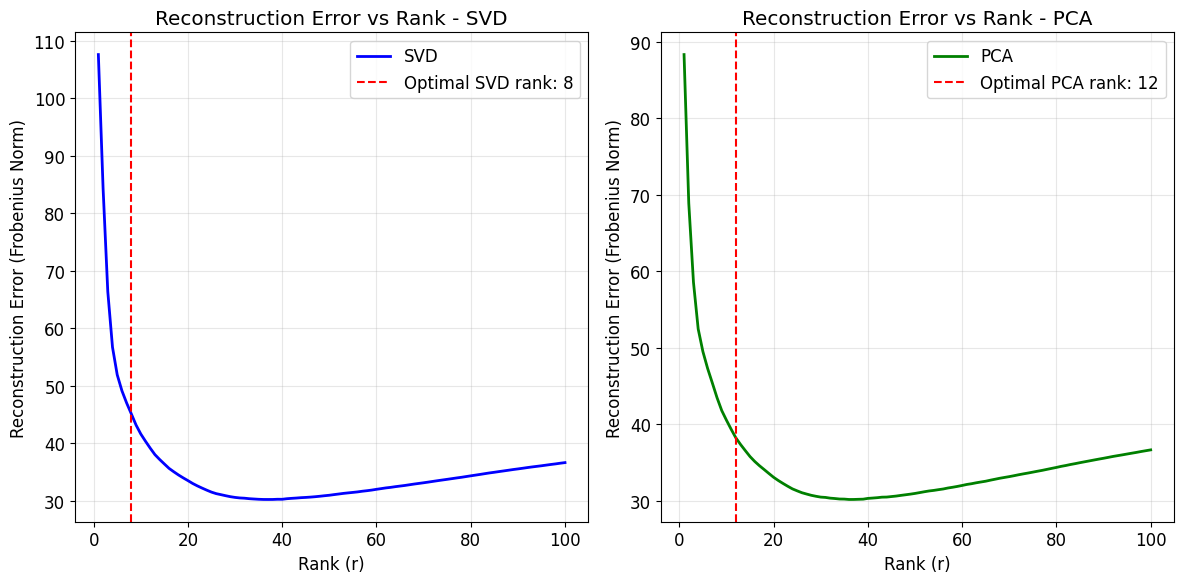

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(ranks, errors_svd, 'b-', linewidth=2, label='SVD')
plt.axvline(x=r_opt_svd, color='r', linestyle='--', label=f'Optimal SVD rank: {r_opt_svd}')
plt.xlabel('Rank (r)')
plt.ylabel('Reconstruction Error (Frobenius Norm)')
plt.title('Reconstruction Error vs Rank - SVD')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ranks, errors_pca, 'g-', linewidth=2, label='PCA')
plt.axvline(x=r_opt_pca, color='r', linestyle='--', label=f'Optimal PCA rank: {r_opt_pca}')
plt.xlabel('Rank (r)')
plt.ylabel('Reconstruction Error (Frobenius Norm)')
plt.title('Reconstruction Error vs Rank - PCA')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

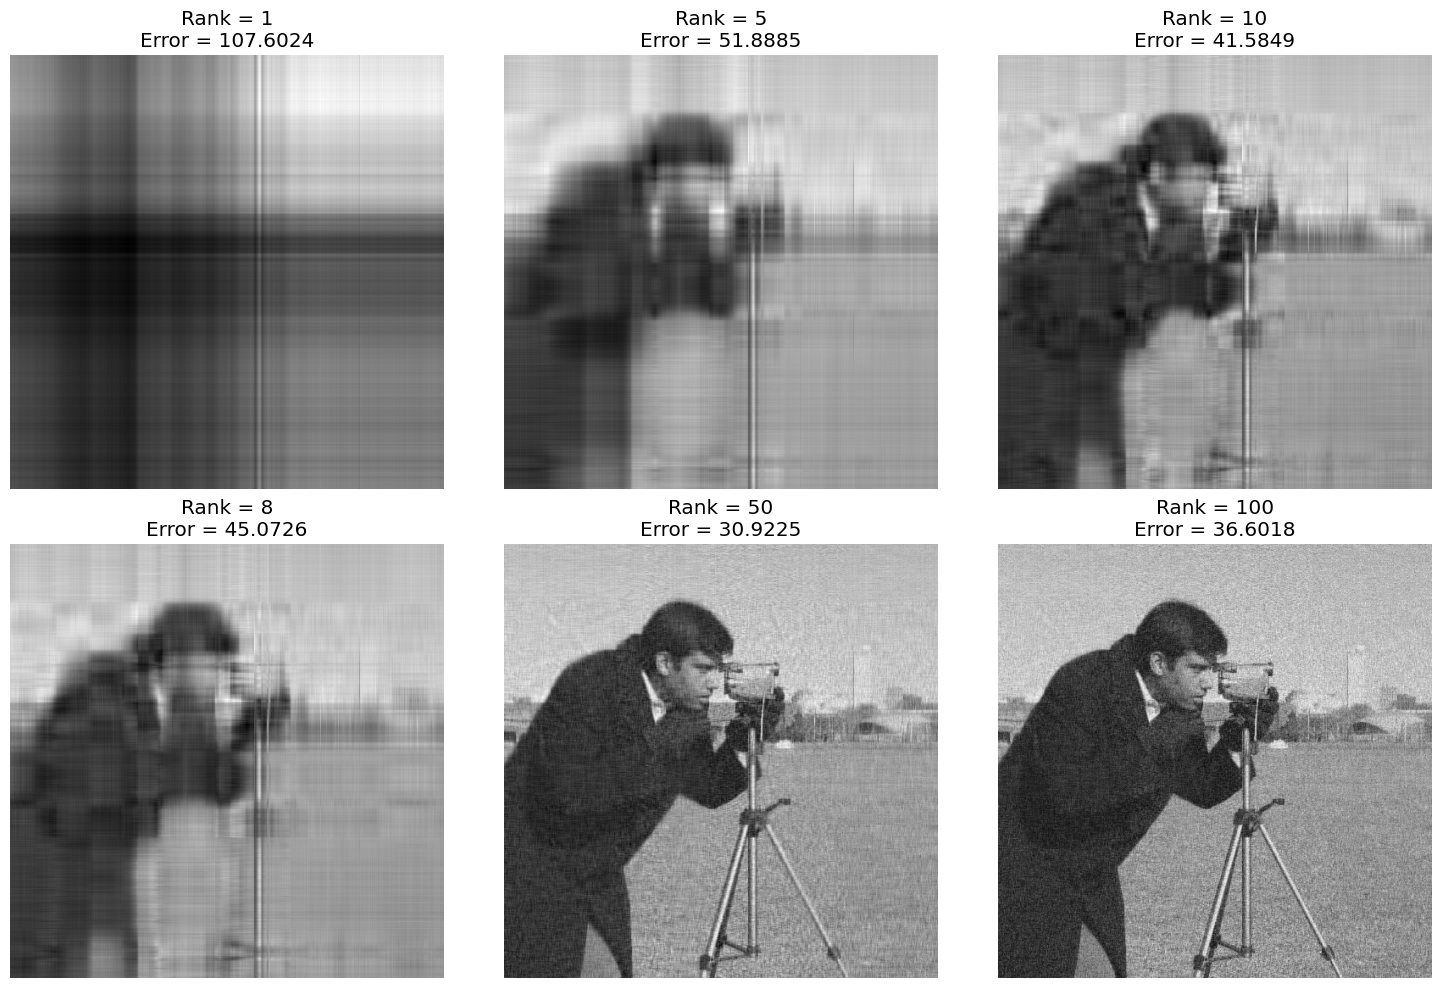

In [13]:
r_samples = [1, 5, 10, r_opt_svd, 50, 100]
n_samples = len(r_samples)

plt.figure(figsize=(15, 10))
for i, r in enumerate(r_samples):
    if r <= max_r_for_plot:
        plt.subplot(2, 3, i+1)
        X_reconstructed = reconstructed_images_svd[r-1]
        plt.imshow(X_reconstructed, cmap='gray')
        error = np.linalg.norm(X - X_reconstructed, 'fro')
        plt.title(f'Rank = {r}\nError = {error:.4f}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# Design Autoencoder Architecture

In [14]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, r_star):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, r_star),
            nn.ReLU(),
            nn.Linear(r_star, r_star // 2),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(r_star // 2, r_star),
            nn.ReLU(),
            nn.Linear(r_star, input_dim),
            nn.Sigmoid()  
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
input_dim = height * width
r_star = min(r_opt_svd, r_opt_pca)  #
print(f"Latent dimension (r*): {r_star}")
print(f"Compressed dimension: {r_star // 2}")

Latent dimension (r*): 8
Compressed dimension: 4


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_dim, r_star).to(device)

print("Autoencoder Architecture:")
print(model)

Autoencoder Architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=262144, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=262144, bias=True)
    (3): Sigmoid()
  )
)


# Preparing Data for Training

In [17]:
X_tensor = torch.FloatTensor(X_noisy.flatten()).unsqueeze(0).to(device)  
y_tensor = torch.FloatTensor(X.flatten()).unsqueeze(0).to(device)        
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training Autoencoder

In [18]:
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    scheduler.step()
    train_losses.append(total_loss / len(dataloader))
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.6f}')

Epoch [20/200], Loss: 0.082153
Epoch [40/200], Loss: 0.076225
Epoch [60/200], Loss: 0.071188
Epoch [80/200], Loss: 0.067694
Epoch [100/200], Loss: 0.064070
Epoch [120/200], Loss: 0.062134
Epoch [140/200], Loss: 0.060284
Epoch [160/200], Loss: 0.058849
Epoch [180/200], Loss: 0.057927
Epoch [200/200], Loss: 0.057008


# Evaluating Autoencoder

In [19]:
model.eval()
with torch.no_grad():
    X_reconstructed_ae = model(X_tensor)
    
    X_reconstructed_ae_np = X_reconstructed_ae.cpu().numpy().reshape(height, width)
    
    error_ae = np.linalg.norm(X - X_reconstructed_ae_np, 'fro')
    
print(f"Autoencoder reconstruction error: {error_ae:.4f}")

Autoencoder reconstruction error: 122.1977


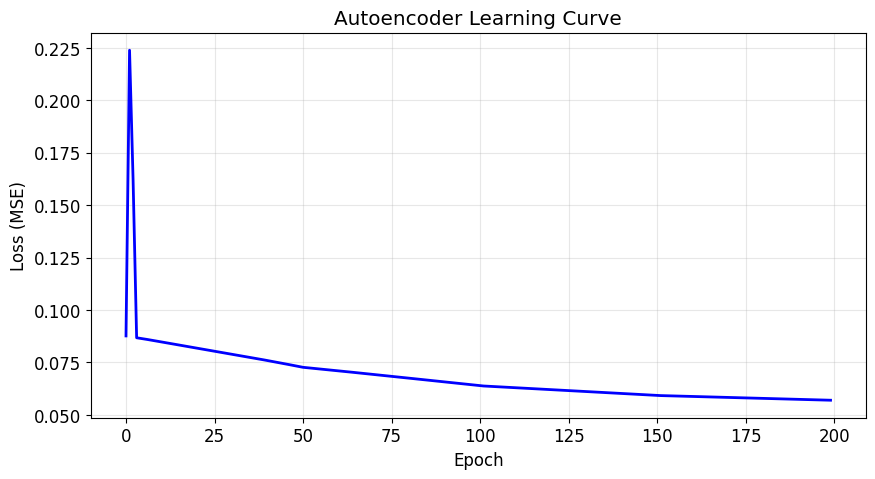

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Autoencoder Learning Curve')
plt.grid(True, alpha=0.3)
plt.show()

# Visual Comparison of Methods

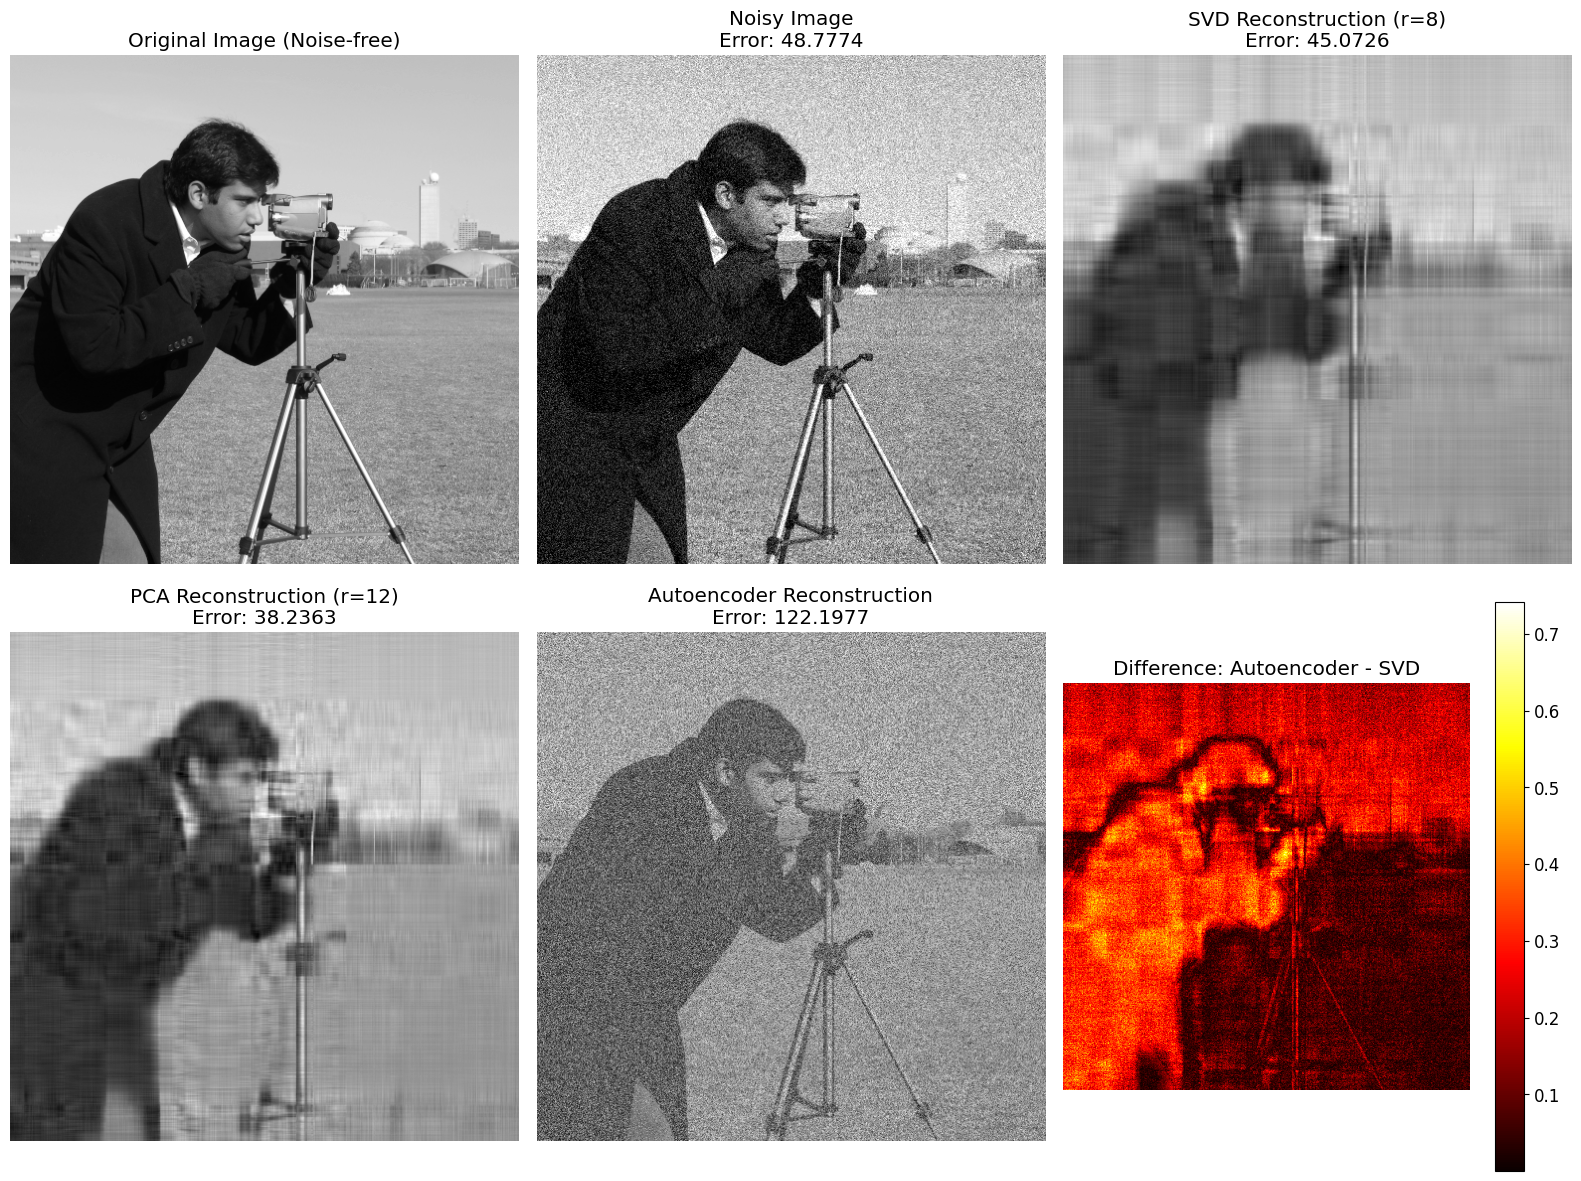

In [21]:
X_reconstructed_svd_opt = reconstructed_images_svd[r_opt_svd - 1]
error_svd_opt = np.linalg.norm(X - X_reconstructed_svd_opt, 'fro')

X_transformed = pca_img.transform(X_noisy)
X_transformed_r = X_transformed.copy()
X_transformed_r[:, r_opt_pca:] = 0
X_reconstructed_pca_opt = pca_img.inverse_transform(X_transformed_r)
error_pca_opt = np.linalg.norm(X - X_reconstructed_pca_opt, 'fro')

plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image (Noise-free)')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(X_noisy, cmap='gray')
plt.title(f'Noisy Image\nError: {noise_error:.4f}')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(X_reconstructed_svd_opt, cmap='gray')
plt.title(f'SVD Reconstruction (r={r_opt_svd})\nError: {error_svd_opt:.4f}')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(X_reconstructed_pca_opt, cmap='gray')
plt.title(f'PCA Reconstruction (r={r_opt_pca})\nError: {error_pca_opt:.4f}')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(X_reconstructed_ae_np, cmap='gray')
plt.title(f'Autoencoder Reconstruction\nError: {error_ae:.4f}')
plt.axis('off')

plt.subplot(2, 3, 6)
diff_ae_svd = np.abs(X_reconstructed_ae_np - X_reconstructed_svd_opt)
plt.imshow(diff_ae_svd, cmap='hot')
plt.title('Difference: Autoencoder - SVD')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

# Quantitative Comparison

In [22]:
comparison_data = {
    'Method': ['Noisy Image', 'SVD (Optimal r)', 'PCA (Optimal r)', 'Autoencoder'],
    'Reconstruction Error': [noise_error, error_svd_opt, error_pca_opt, error_ae],
    'Latent Dimension': ['-', r_opt_svd, r_opt_pca, r_star]
}

print("Performance Comparison of Different Methods:")
for i in range(len(comparison_data['Method'])):
    print(f"{comparison_data['Method'][i]:25s} | Error: {comparison_data['Reconstruction Error'][i]:.4f} | Latent Dim: {comparison_data['Latent Dimension'][i]}")

improvements = []
for i in range(1, len(comparison_data['Reconstruction Error'])):
    improvement = 100 * (noise_error - comparison_data['Reconstruction Error'][i]) / noise_error
    improvements.append(improvement)

print(f"\nPercentage improvement relative to noisy image:")
print(f"  SVD:        {improvements[0]:.2f}%")
print(f"  PCA:        {improvements[1]:.2f}%")
print(f"  Autoencoder: {improvements[2]:.2f}%")

if error_ae < error_svd_opt:
    print(f"\nAutoencoder performs better than SVD ({(error_svd_opt - error_ae)/error_svd_opt*100:.2f}% improvement).")
else:
    print(f"\nSVD performs better than Autoencoder ({(error_ae - error_svd_opt)/error_ae*100:.2f}% improvement).")

Performance Comparison of Different Methods:
Noisy Image               | Error: 48.7774 | Latent Dim: -
SVD (Optimal r)           | Error: 45.0726 | Latent Dim: 8
PCA (Optimal r)           | Error: 38.2363 | Latent Dim: 12
Autoencoder               | Error: 122.1977 | Latent Dim: 8

Percentage improvement relative to noisy image:
  SVD:        7.60%
  PCA:        21.61%
  Autoencoder: -150.52%

SVD performs better than Autoencoder (63.12% improvement).
